**Market Sentiment Analysis for Bitcoin and Ethereum using VADER**

In [1]:
# Step 0: Install and import required libraries
!pip install nltk
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Download VADER lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
# Step 1: Load datasets
tweets_path = '/content/Tweets_Crypto_2013-2021.csv'
btc_path = '/content/bitcoin_unnormalized.xlsx'
eth_path = '/content/ethereum_unnormalized.xlsx'

tweets_df = pd.read_csv(tweets_path)
btc_df = pd.read_excel(btc_path)
eth_df = pd.read_excel(eth_path)

In [10]:
# Step 2: Preprocess dates
tweets_df['date'] = pd.to_datetime(tweets_df['date'])
btc_df['Date'] = pd.to_datetime(btc_df['Date'])
eth_df['Date'] = pd.to_datetime(eth_df['Date'])

# Fill missing tweet texts to avoid errors
tweets_df['tweet'] = tweets_df['tweet'].fillna('')

In [11]:
# Step 3: Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

In [12]:
# Step 4: Apply VADER sentiment analysis efficiently
def get_vader_scores(text):
    scores = sia.polarity_scores(str(text))
    return pd.Series([scores['compound'], scores['pos'], scores['neg'], scores['neu']])

tweets_df[['compound', 'pos', 'neg', 'neu']] = tweets_df['tweet'].apply(get_vader_scores)

In [13]:
# Step 5: Aggregate daily sentiment by date (mean compound score)
daily_sentiment = tweets_df.groupby('date')['compound'].mean().reset_index()
daily_sentiment.rename(columns={'date': 'Date', 'compound': 'sentiment_score'}, inplace=True)

In [14]:
# Step 6: Merge daily sentiment with Bitcoin data
btc_merged = pd.merge(btc_df, daily_sentiment, on='Date', how='left')
btc_merged['sentiment_score'] = btc_merged['sentiment_score'].fillna(0)

In [15]:
# Step 7: Merge daily sentiment with Ethereum data
eth_merged = pd.merge(eth_df, daily_sentiment, on='Date', how='left')
eth_merged['sentiment_score'] = eth_merged['sentiment_score'].fillna(0)

In [16]:
# Step 8: Analyze correlations and plot

# BTC correlation between sentiment and daily return
print("BTC correlation between sentiment_score and Daily_Return:")
print(btc_merged[['sentiment_score', 'Daily_Return']].corr())

# ETH correlation between sentiment and daily return
print("ETH correlation between sentiment_score and Daily_Return:")
print(eth_merged[['sentiment_score', 'Daily_Return']].corr())

BTC correlation between sentiment_score and Daily_Return:
                 sentiment_score  Daily_Return
sentiment_score         1.000000      0.008676
Daily_Return            0.008676      1.000000
ETH correlation between sentiment_score and Daily_Return:
                 sentiment_score  Daily_Return
sentiment_score         1.000000      0.007963
Daily_Return            0.007963      1.000000


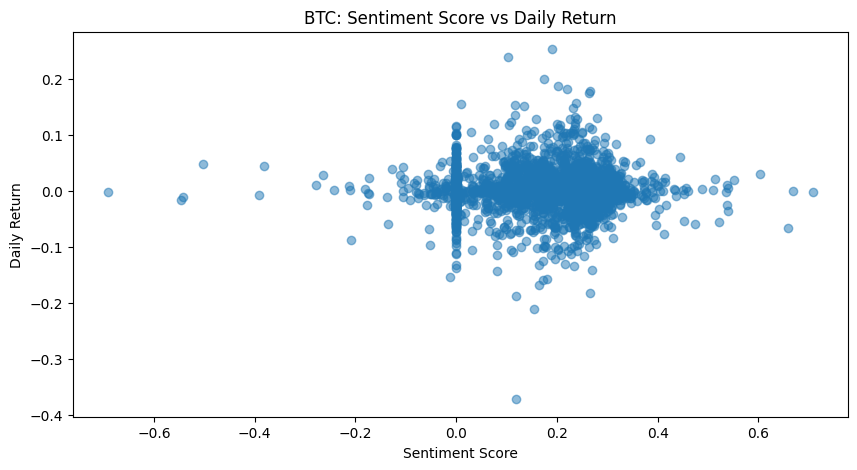

In [17]:
# Step 9: Plot

# Plot BTC sentiment vs daily return
plt.figure(figsize=(10,5))
plt.scatter(btc_merged['sentiment_score'], btc_merged['Daily_Return'], alpha=0.5)
plt.title('BTC: Sentiment Score vs Daily Return')
plt.xlabel('Sentiment Score')
plt.ylabel('Daily Return')
plt.show()

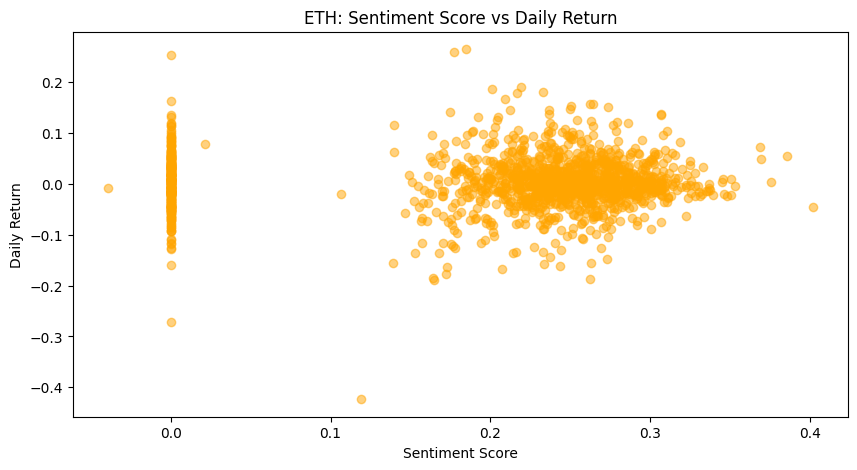

In [18]:
# Plot ETH sentiment vs daily return
plt.figure(figsize=(10,5))
plt.scatter(eth_merged['sentiment_score'], eth_merged['Daily_Return'], alpha=0.5, color='orange')
plt.title('ETH: Sentiment Score vs Daily Return')
plt.xlabel('Sentiment Score')
plt.ylabel('Daily Return')
plt.show()

In [25]:
print(btc_merged.columns)

Index(['Date', 'Open_BTC-USD', 'High_BTC-USD', 'Low_BTC-USD', 'Close_BTC-USD',
       'Volume_BTC-USD', 'Volatility', 'MA_7', 'MA_30', 'Daily_Return'],
      dtype='object')


In [26]:
# Merge daily sentiment with Bitcoin data
btc_merged = pd.merge(btc_df, daily_sentiment, on='Date', how='left')
# Fill missing sentiment with 0
btc_merged['sentiment_score'] = btc_merged['sentiment_score'].fillna(0)
# Now copy it to Sentiment_Score column
btc_merged['Sentiment_Score'] = btc_merged['sentiment_score']
# Drop the extra column if you want
btc_merged.drop(columns=['sentiment_score'], inplace=True)

# Same for Ethereum
eth_merged = pd.merge(eth_df, daily_sentiment, on='Date', how='left')
eth_merged['sentiment_score'] = eth_merged['sentiment_score'].fillna(0)
eth_merged['Sentiment_Score'] = eth_merged['sentiment_score']
eth_merged.drop(columns=['sentiment_score'], inplace=True)

In [27]:
print(btc_merged.columns)
print(eth_merged.columns)

Index(['Date', 'Open_BTC-USD', 'High_BTC-USD', 'Low_BTC-USD', 'Close_BTC-USD',
       'Volume_BTC-USD', 'Volatility', 'MA_7', 'MA_30', 'Daily_Return',
       'Sentiment_Score'],
      dtype='object')
Index(['Date', 'ETH-USD_Open', 'ETH-USD_High', 'ETH-USD_Low', 'ETH-USD_Close',
       'ETH-USD_Volume', 'Volatility', 'MA_7', 'MA_30', 'Daily_Return',
       'Sentiment_Score'],
      dtype='object')


In [28]:
def sentiment_category(score):
    if score > 0.6:
        return 'Very High'
    elif score > 0.2:
        return 'High'
    elif score >= -0.2:
        return 'Neutral'
    elif score >= -0.6:
        return 'Low'
    else:
        return 'Very Low'

# Apply to btc_merged
btc_merged['Sentiment_Category'] = btc_merged['Sentiment_Score'].apply(sentiment_category)

# Apply to eth_merged
eth_merged['Sentiment_Category'] = eth_merged['Sentiment_Score'].apply(sentiment_category)

In [29]:
# 1. Average Daily Return per Sentiment Category

btc_return_by_sentiment = btc_merged.groupby('Sentiment_Category')['Daily_Return'].mean()
eth_return_by_sentiment = eth_merged.groupby('Sentiment_Category')['Daily_Return'].mean()

print("BTC Avg Daily Return by Sentiment:\n", btc_return_by_sentiment)
print("\nETH Avg Daily Return by Sentiment:\n", eth_return_by_sentiment)

BTC Avg Daily Return by Sentiment:
 Sentiment_Category
High         0.002852
Low          0.001900
Neutral      0.002144
Very High   -0.010033
Very Low    -0.001687
Name: Daily_Return, dtype: float64

ETH Avg Daily Return by Sentiment:
 Sentiment_Category
High       0.004471
Neutral   -0.000346
Name: Daily_Return, dtype: float64


In [30]:
#  2. Count of Days per Sentiment Category

btc_sentiment_counts = btc_merged['Sentiment_Category'].value_counts()
eth_sentiment_counts = eth_merged['Sentiment_Category'].value_counts()

print("BTC Days by Sentiment Category:\n", btc_sentiment_counts)
print("\nETH Days by Sentiment Category:\n", eth_sentiment_counts)

BTC Days by Sentiment Category:
 Sentiment_Category
High         1349
Neutral      1297
Low            11
Very High       4
Very Low        1
Name: count, dtype: int64

ETH Days by Sentiment Category:
 Sentiment_Category
High       1049
Neutral     445
Name: count, dtype: int64


In [31]:
# 3. Average Volatility by Sentiment

btc_vol_by_sentiment = btc_merged.groupby('Sentiment_Category')['Volatility'].mean()
eth_vol_by_sentiment = eth_merged.groupby('Sentiment_Category')['Volatility'].mean()

print("BTC Avg Volatility by Sentiment:\n", btc_vol_by_sentiment)
print("\nETH Avg Volatility by Sentiment:\n", eth_vol_by_sentiment)

BTC Avg Volatility by Sentiment:
 Sentiment_Category
High         0.042496
Low          0.049485
Neutral      0.051612
Very High    0.039175
Very Low     0.017925
Name: Volatility, dtype: float64

ETH Avg Volatility by Sentiment:
 Sentiment_Category
High       0.058932
Neutral    0.086636
Name: Volatility, dtype: float64


In [34]:
# 4. Average Trading Volume by Sentiment

btc_volume_by_sentiment = btc_merged.groupby('Sentiment_Category')['Volume_BTC-USD'].mean()
eth_volume_by_sentiment = eth_merged.groupby('Sentiment_Category')['ETH-USD_Volume'].mean()

print("BTC Avg Volume by Sentiment:\n", btc_volume_by_sentiment)
print("\nETH Avg Volume by Sentiment:\n", eth_volume_by_sentiment)

BTC Avg Volume by Sentiment:
 Sentiment_Category
High         1.455623e+10
Low          2.494665e+07
Neutral      1.454166e+10
Very High    3.279135e+07
Very Low     1.238790e+07
Name: Volume_BTC-USD, dtype: float64

ETH Avg Volume by Sentiment:
 Sentiment_Category
High       8.055319e+09
Neutral    2.215464e+10
Name: ETH-USD_Volume, dtype: float64


In [35]:
#  5. Price Change Direction Count by Sentiment

btc_merged['Price_Up'] = btc_merged['Daily_Return'] > 0
eth_merged['Price_Up'] = eth_merged['Daily_Return'] > 0

btc_price_trend = btc_merged.groupby('Sentiment_Category')['Price_Up'].value_counts().unstack().fillna(0)
eth_price_trend = eth_merged.groupby('Sentiment_Category')['Price_Up'].value_counts().unstack().fillna(0)

print("BTC Price Up/Down Counts by Sentiment:\n", btc_price_trend)
print("\nETH Price Up/Down Counts by Sentiment:\n", eth_price_trend)

BTC Price Up/Down Counts by Sentiment:
 Price_Up            False  True 
Sentiment_Category              
High                622.0  727.0
Low                   4.0    7.0
Neutral             588.0  709.0
Very High             3.0    1.0
Very Low              1.0    0.0

ETH Price Up/Down Counts by Sentiment:
 Price_Up            False  True 
Sentiment_Category              
High                  501    548
Neutral               213    232


<ipython-input-41-edd5d1282e99>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Sentiment_Category", y="Daily_Return", data=btc_return_by_sentiment, ax=axs[0, 0], palette="Blues_d")
<ipython-input-41-edd5d1282e99>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Sentiment_Category", y="Daily_Return", data=eth_return_by_sentiment, ax=axs[0, 1], palette="Greens_d")
<ipython-input-41-edd5d1282e99>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Sentiment_Category", y="Count", data=btc_sentiment_counts, ax=axs[1, 0], palette="Blues

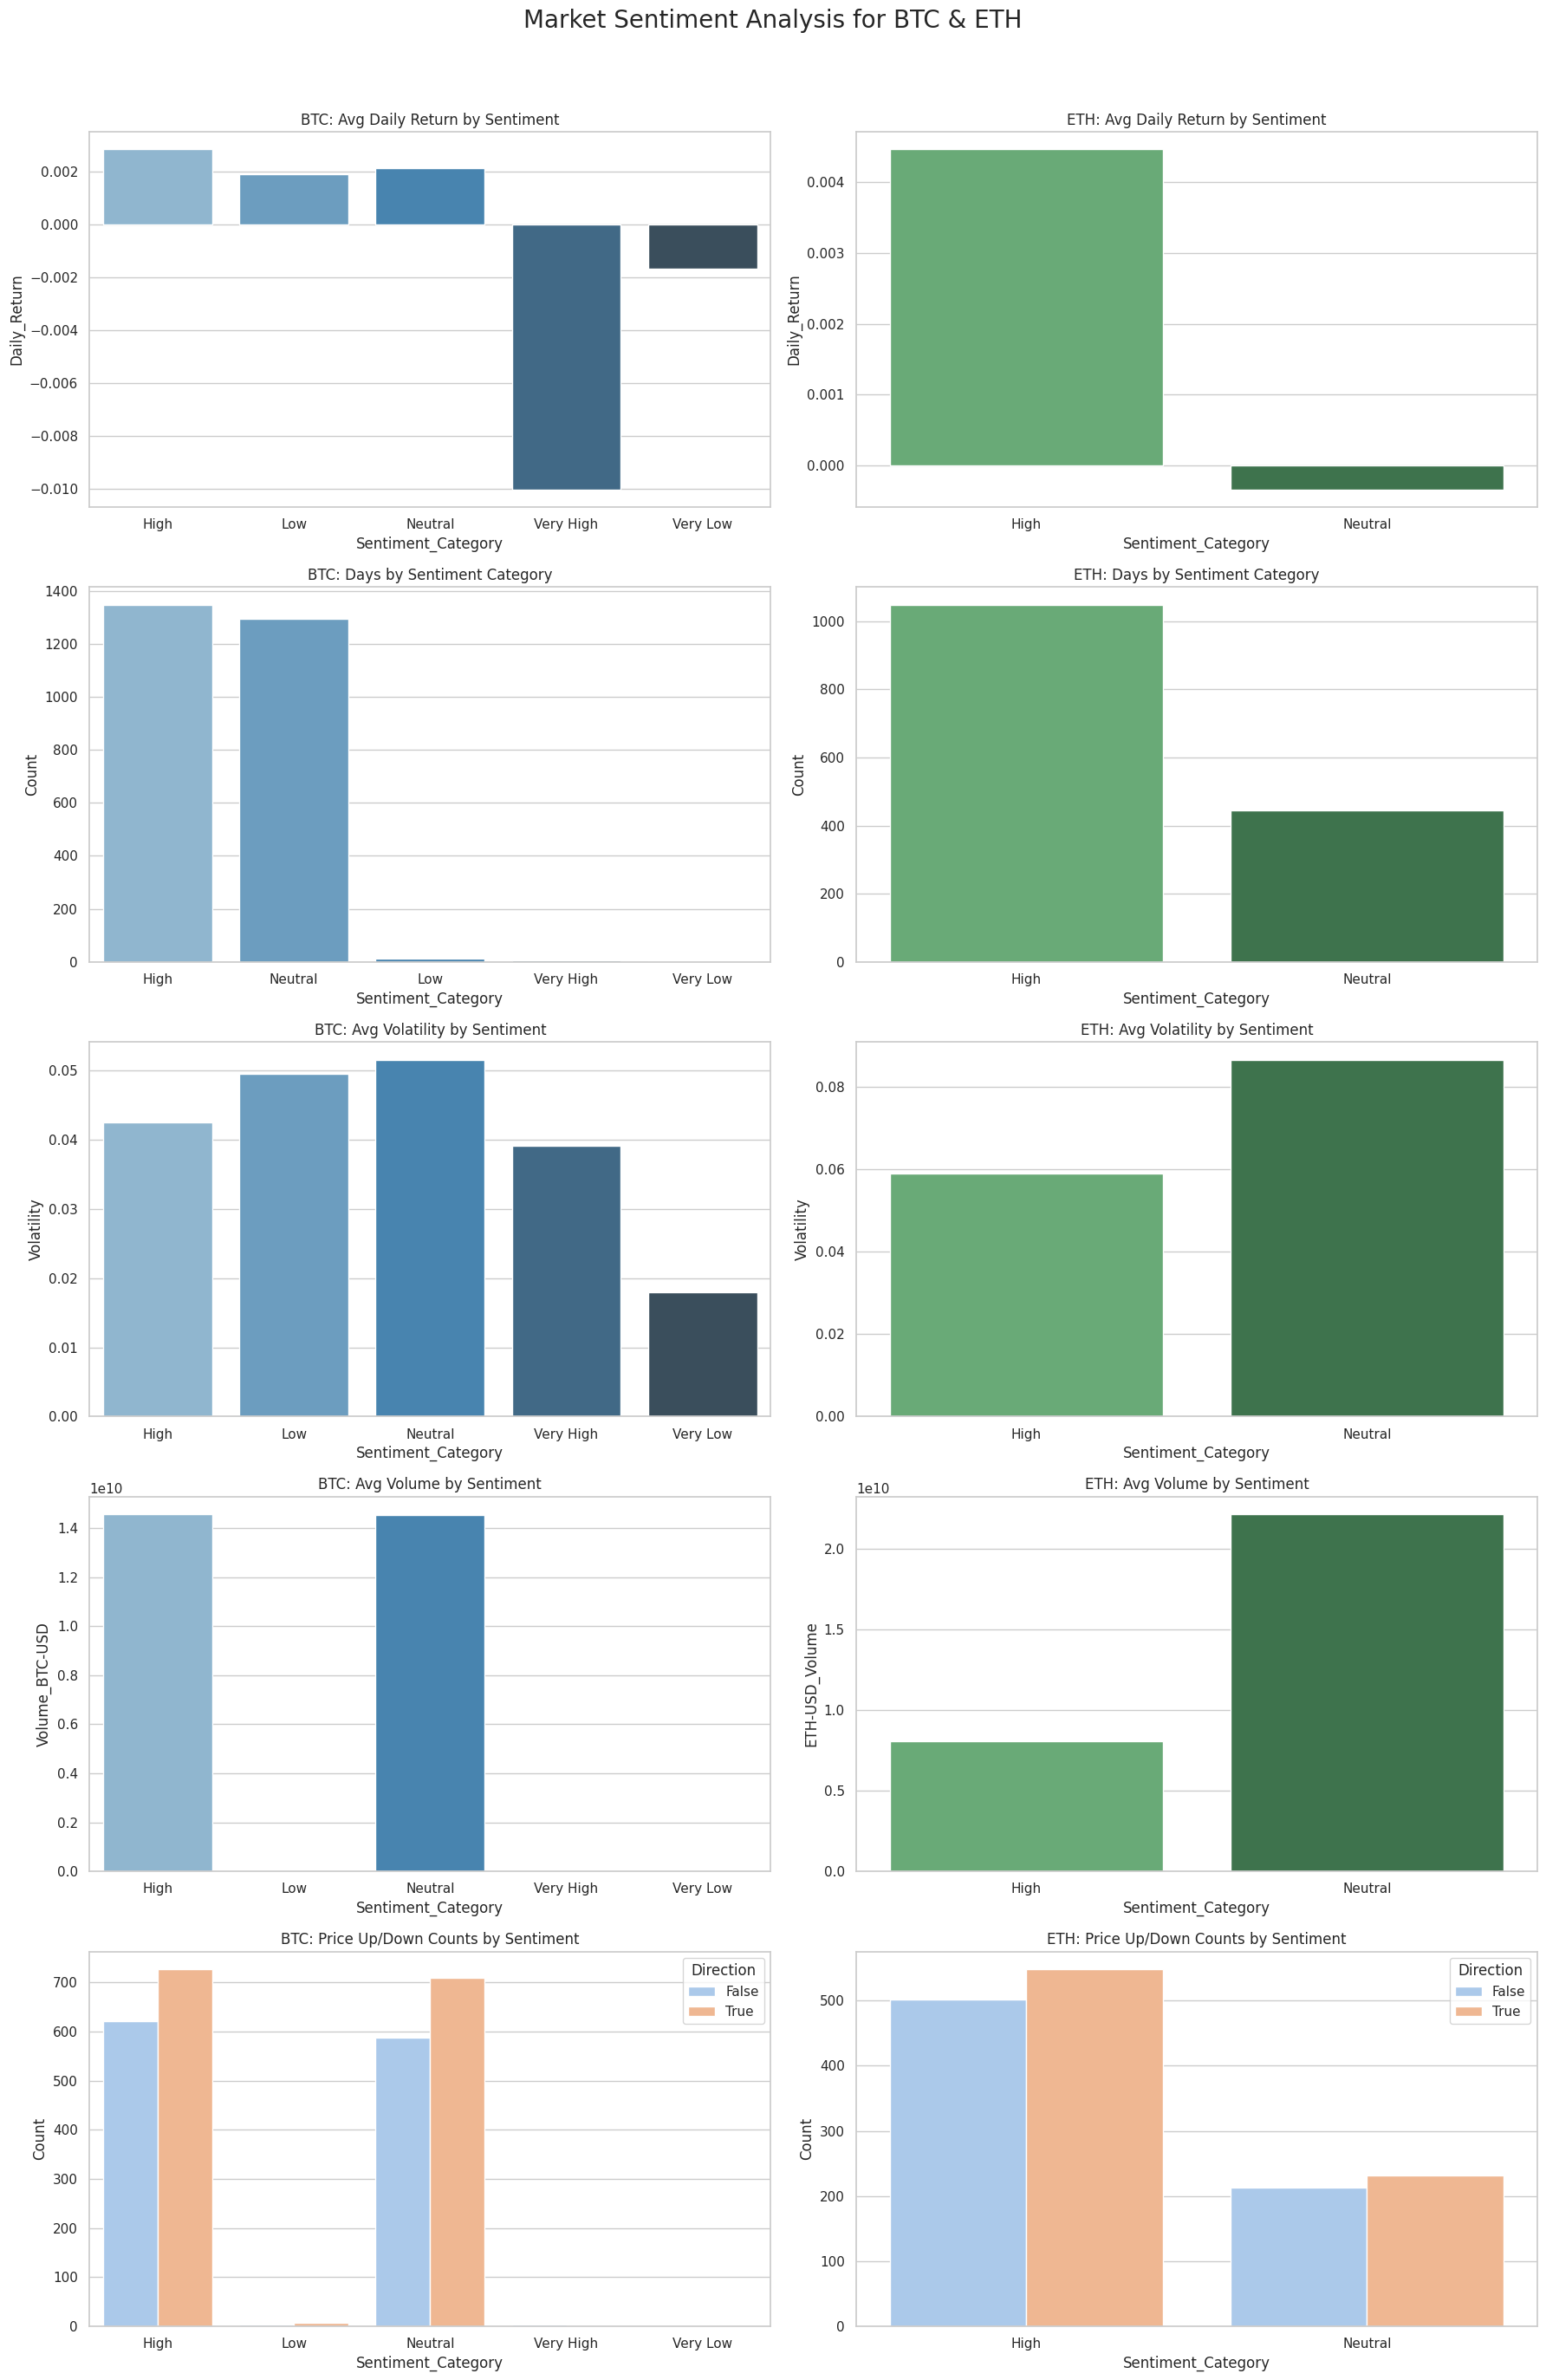

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# 1. Avg Daily Return per Sentiment Category
btc_return_by_sentiment = btc_merged.groupby('Sentiment_Category')['Daily_Return'].mean().reset_index()
eth_return_by_sentiment = eth_merged.groupby('Sentiment_Category')['Daily_Return'].mean().reset_index()

# 2. Count of Days per Sentiment Category
btc_sentiment_counts = btc_merged['Sentiment_Category'].value_counts().reset_index()
btc_sentiment_counts.columns = ['Sentiment_Category', 'Count']
eth_sentiment_counts = eth_merged['Sentiment_Category'].value_counts().reset_index()
eth_sentiment_counts.columns = ['Sentiment_Category', 'Count']

# 3. Avg Volatility
btc_vol_by_sentiment = btc_merged.groupby('Sentiment_Category')['Volatility'].mean().reset_index()
eth_vol_by_sentiment = eth_merged.groupby('Sentiment_Category')['Volatility'].mean().reset_index()

# 4. Avg Trading Volume
btc_volume_by_sentiment = btc_merged.groupby('Sentiment_Category')['Volume_BTC-USD'].mean().reset_index()
eth_volume_by_sentiment = eth_merged.groupby('Sentiment_Category')['ETH-USD_Volume'].mean().reset_index()

# 5. Price Change Direction Counts
btc_merged['Price_Up'] = btc_merged['Daily_Return'] > 0
eth_merged['Price_Up'] = eth_merged['Daily_Return'] > 0
btc_price_trend = btc_merged.groupby('Sentiment_Category')['Price_Up'].value_counts().unstack().fillna(0).reset_index()
eth_price_trend = eth_merged.groupby('Sentiment_Category')['Price_Up'].value_counts().unstack().fillna(0).reset_index()

# Plotting
fig, axs = plt.subplots(5, 2, figsize=(18, 28))
fig.suptitle("Market Sentiment Analysis for BTC & ETH", fontsize=20)

# 1. Avg Daily Return
sns.barplot(x="Sentiment_Category", y="Daily_Return", data=btc_return_by_sentiment, ax=axs[0, 0], palette="Blues_d")
axs[0, 0].set_title("BTC: Avg Daily Return by Sentiment")

sns.barplot(x="Sentiment_Category", y="Daily_Return", data=eth_return_by_sentiment, ax=axs[0, 1], palette="Greens_d")
axs[0, 1].set_title("ETH: Avg Daily Return by Sentiment")

# 2. Count of Days
sns.barplot(x="Sentiment_Category", y="Count", data=btc_sentiment_counts, ax=axs[1, 0], palette="Blues_d")
axs[1, 0].set_title("BTC: Days by Sentiment Category")

sns.barplot(x="Sentiment_Category", y="Count", data=eth_sentiment_counts, ax=axs[1, 1], palette="Greens_d")
axs[1, 1].set_title("ETH: Days by Sentiment Category")

# 3. Volatility
sns.barplot(x="Sentiment_Category", y="Volatility", data=btc_vol_by_sentiment, ax=axs[2, 0], palette="Blues_d")
axs[2, 0].set_title("BTC: Avg Volatility by Sentiment")

sns.barplot(x="Sentiment_Category", y="Volatility", data=eth_vol_by_sentiment, ax=axs[2, 1], palette="Greens_d")
axs[2, 1].set_title("ETH: Avg Volatility by Sentiment")

# 4. Volume
sns.barplot(x="Sentiment_Category", y="Volume_BTC-USD", data=btc_volume_by_sentiment, ax=axs[3, 0], palette="Blues_d")
axs[3, 0].set_title("BTC: Avg Volume by Sentiment")

sns.barplot(x="Sentiment_Category", y="ETH-USD_Volume", data=eth_volume_by_sentiment, ax=axs[3, 1], palette="Greens_d")
axs[3, 1].set_title("ETH: Avg Volume by Sentiment")

# 5. Price Direction Counts
btc_melt = btc_price_trend.melt(id_vars="Sentiment_Category", var_name="Direction", value_name="Count")
eth_melt = eth_price_trend.melt(id_vars="Sentiment_Category", var_name="Direction", value_name="Count")

sns.barplot(x="Sentiment_Category", y="Count", hue="Direction", data=btc_melt, ax=axs[4, 0], palette="pastel")
axs[4, 0].set_title("BTC: Price Up/Down Counts by Sentiment")

sns.barplot(x="Sentiment_Category", y="Count", hue="Direction", data=eth_melt, ax=axs[4, 1], palette="pastel")
axs[4, 1].set_title("ETH: Price Up/Down Counts by Sentiment")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [43]:
# Save BTC and ETH data with sentiment scores
btc_merged.to_csv('/content/btc_with_sentiment.csv', index=False)
eth_merged.to_csv('/content/eth_with_sentiment.csv', index=False)

from google.colab import files

# Download the files
files.download('/content/btc_with_sentiment.csv')
files.download('/content/eth_with_sentiment.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>